<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Автор: [Yury Kashnitsky](https://yorko.github.io). Все материалы распространяются под [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).

# Задание #3
## Деревья решений для классификации и регрессии

В этом задании мы выясним, как работает дерево решений в задаче регрессии, а затем построим и настроим классификационные деревья решений для выявления заболеваний сердца.

### Задача состоит в том, чтобы:
 1. написать код и выполнить вычисления в ячейках ниже;
 2. выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1ZUYREiTJjg8IiZAIIMdWRODtPe1qfC0UBYq_i2WFe1c/). 
    

*Если вы уверены, что в задании/решении что-то не на 100% верно, пожалуйста, оставьте свой отзыв через указанную веб-форму ↑*.

-----

In [1]:
import numpy as np
import pandas as pd

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

## 1. Деревья решений для регрессии: игрушечный пример

Рассмотрим следующую одномерную задачу регрессии. Требуется построить функцию $\large a(x)$ для аппроксимации зависимости $\large y = f(x)$ по критерию среднеквадратичной ошибки: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

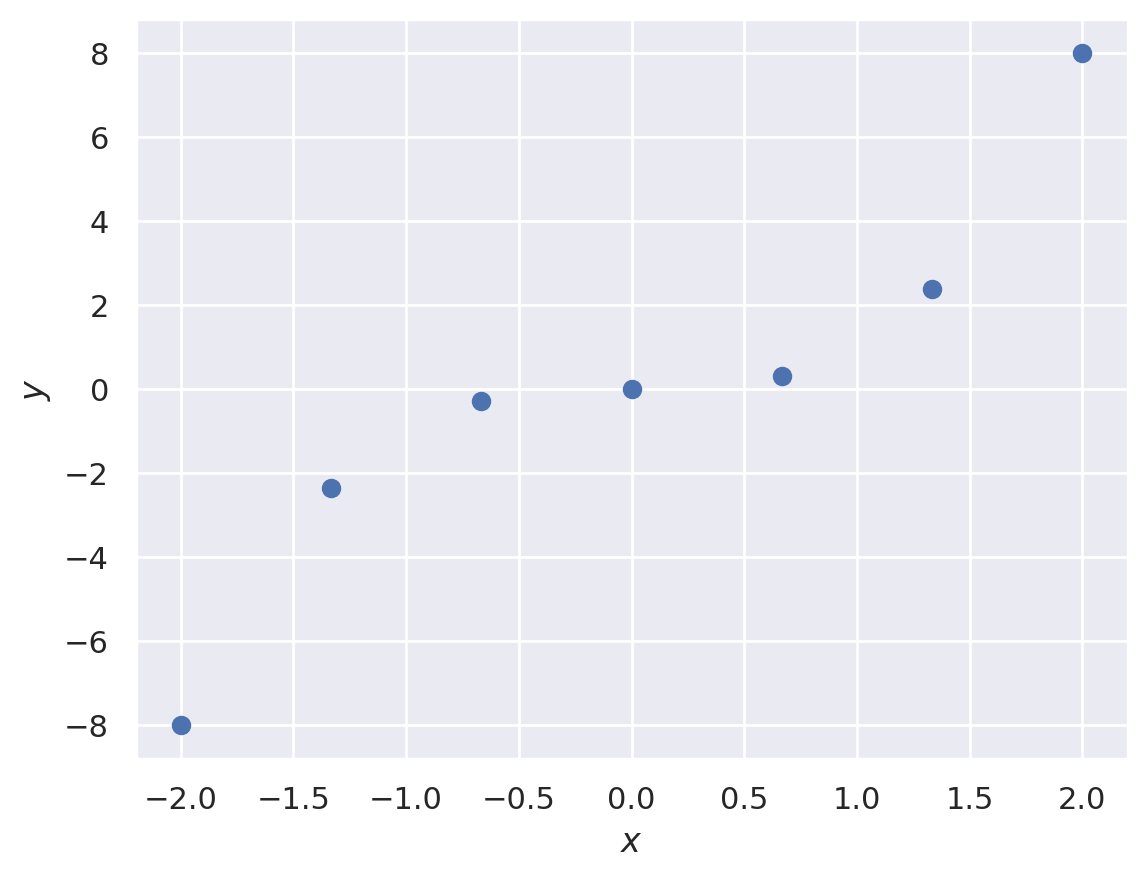

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$");

Выполним несколько шагов для построения дерева решений. В случае задачи **регрессии** в момент предсказания лист возвращает среднее значение для всех наблюдений в этом листе.

Начнем с дерева глубиной 0, т.е. все наблюдения помещены в один лист. 

Необходимо построить дерево с одним узлом (называемым также **корнем**), содержащим все обучающие наблюдения (экземпляры). 

Как будут выглядеть предсказания этого дерева для $x \in [-2, 2]$?

Постройте соответствующий график, используя ручку, бумагу и Python, если необходимо (но `sklearn` пока не нужен).

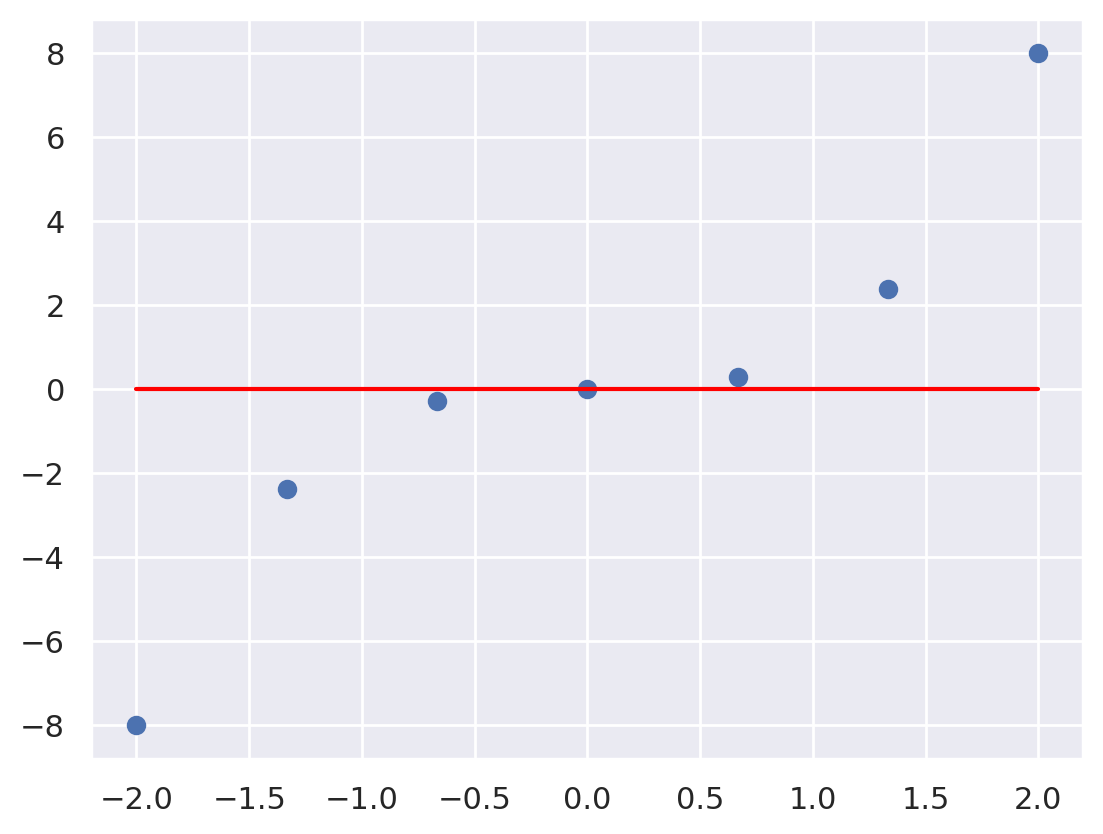

In [3]:
xx = np.linspace(-2, 2, 100)
predictions = [np.mean(y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.plot(xx, predictions, c="red");

**Сделаем первые деления.**

Разобьем данные в соответствии со следующим условием $[x < 0]$. Это дает нам дерево глубины 1 с двумя листьями. Поясним, что для всех случаев с $x \geqslant 0$ дерево будет возвращать одно значение, для всех случаев с $x < 0$ - другое. Построим аналогичный график для предсказаний этого дерева.

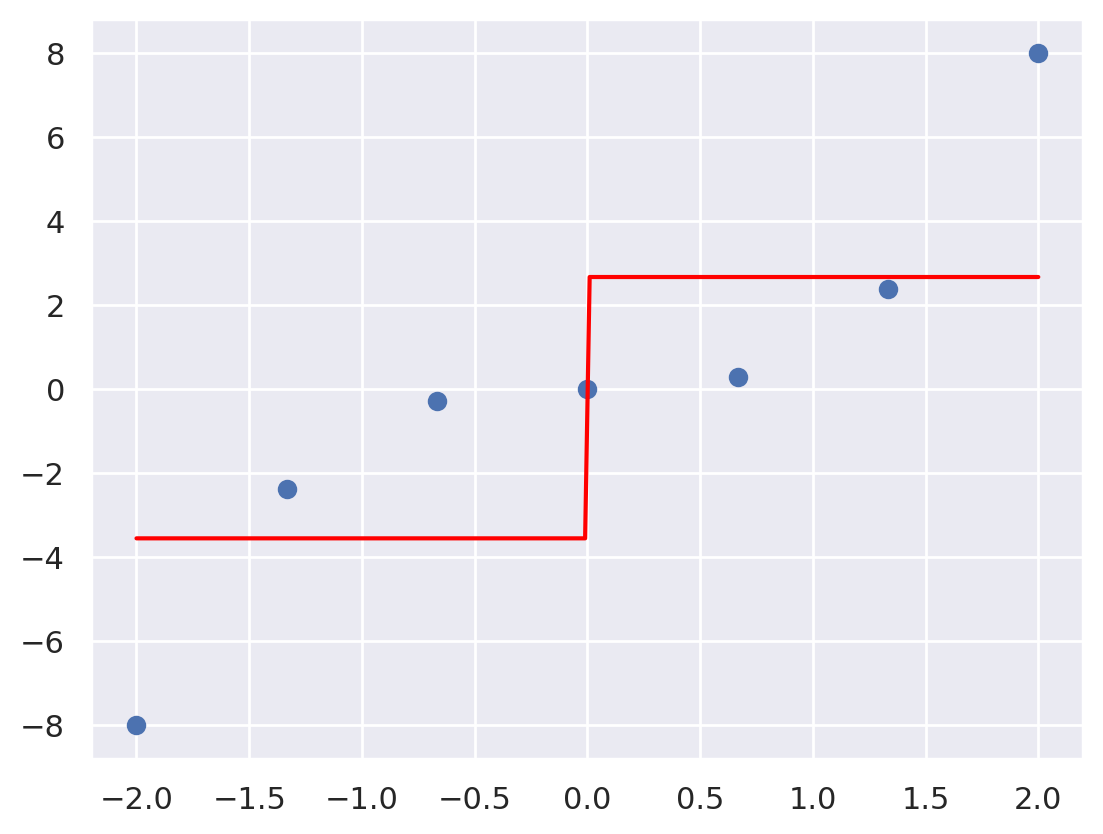

In [4]:
xx = np.linspace(-2, 2, 200)
predictions = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0]) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.plot(xx, predictions, c="red");

В алгоритме дерева решений признак и порог разбиения выбираются в соответствии с некоторым критерием. Для регрессии обычно используется критерий, основанный на дисперсии:

$$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$

где $\large X$ и $\large y$ - матрица признаков и вектор цели (соответственно) для обучающих экземпляров в текущем узле, $\large X_l, y_l$ и $\large X_r, y_r$ - разбиения выборок $\large X, y$ на две части в зависимости от времени. $\large [x_j < t]$ (по $\large j$-му признаку и порогу $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (или, что то же самое, $\large |y|$, $\large |y_l|$, $\large |y_r|$) - размеры соответствующих выборок, а $\large D(X, y)$ - дисперсия ответов $\large y$ для всех экземпляров в $\large X$:

$$\large D(X, y) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$

Здесь $\large y_i = y(x_i)$ - ответ для экземпляра $\large x_i$. Индекс признака $\large j$ и порог $\large t$ выбираются таким образом, чтобы максимизировать значение критерия $\large Q(X, y, j, t)$ для каждого разбиения.

В нашем одномерном случае имеется только один признак, поэтому $\large Q$ зависит только от порога $\large t$ и обучающих данных $\large X$ и $\large y$. Обозначим его $\large Q_{1d}(X, y, t)$, имея в виду, что критерий уже не зависит от индекса признака $\large j$, т.е. в одномерном случае $\large j = 1$.

In [5]:
def regression_var_criterion(X, y, t):
    X_left, X_right = X[X < t], X[X >= t]
    y_left, y_right = y[X < t], y[X >= t]
    return (
        np.var(y)
        - X_left.shape[0] / X.shape[0] * np.var(y_left)
        - X_right.shape[0] / X.shape[0] * np.var(y_right)
    )

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

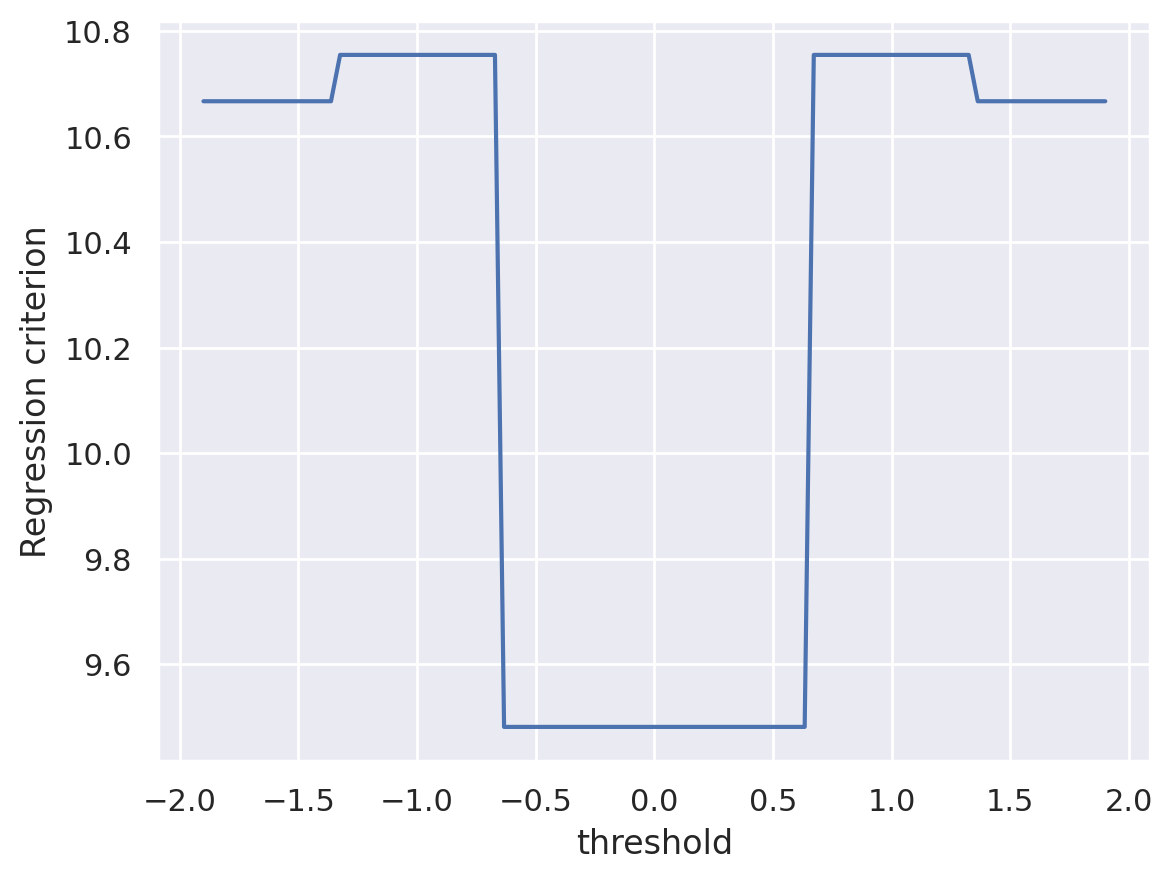

In [6]:
thresholds = np.linspace(-1.9, 1.9, 100)
criterion = [regression_var_criterion(X, y, threshold) for threshold in thresholds]

plt.plot(thresholds, criterion)
plt.xlabel("threshold")
plt.ylabel("Regression criterion");

**1. Каково наихудшее пороговое значение (для выполнения разбиения) в соответствии с дисперсионным критерием?**
- -1.9
- -1.3
- 0
- 1.3
- 1.9

Ответ: 0

Затем произведем разбиение в каждом из узлов листьев. 

Возьмем дерево с первым порогом [$x<0$].

Теперь добавим разбиение в левой ветви (где предыдущее разбиение было $x < 0$) по критерию $[x < -1,5]$, в правой ветви (где предыдущее разбиение было $x \geqslant 0$) по следующему критерию $[x < 1,5]$. 

Получается дерево глубины 2 с 7 узлами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

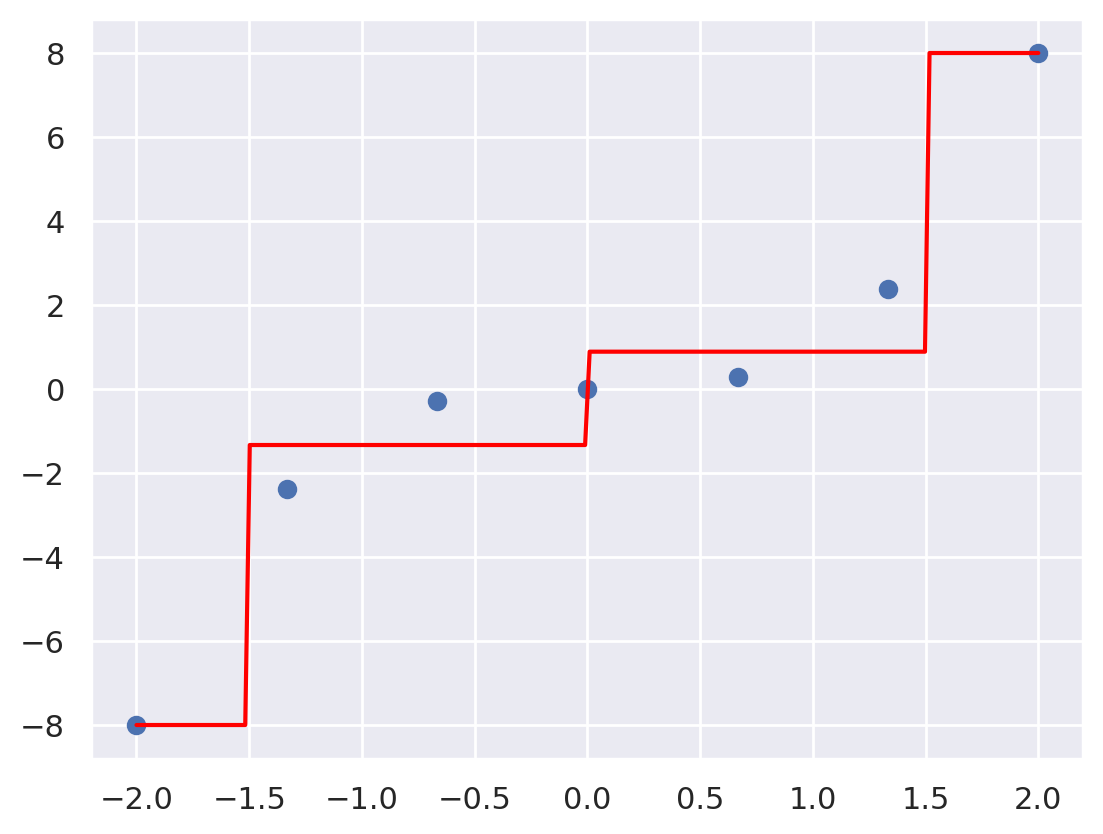

In [7]:
xx = np.linspace(-2, 2, 200)


def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x < 1.5 and x >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x >= -1.5 and x < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])


predictions = [prediction(x, X, y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3  # original dependecy

plt.scatter(X, y)
plt.plot(xx, predictions, c="red");

**2. Предсказания деревьев - кусочно-постоянная функция, верно? Сколько "кусочков" (горизонтальных отрезков на только что построенном графике) находится в интервале [-2, 2]?**
- 2
- 4
- 6
- 8

Ответ: 4

## 2. Построение дерева решений для прогнозирования сердечно-сосудистых заболеваний

### Задача

Прогнозировать наличие или отсутствие сердечно-сосудистых заболеваний (ССЗ) по результатам обследования пациента.

### Описание данных

Существует 3 типа входных признаков:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Признак                                                | Тип переменной      | Переменная  | Тип значения                                     |
|--------------------------------------------------------|---------------------|-------------|--------------------------------------------------|
| Возраст                                                | Objective Feature   | age         | int (days)                                       |
| Рост                                                   | Objective Feature   | height      | int (cm)                                         |
| Вес                                                    | Objective Feature   | weight      | float (kg)                                       |
| Пол                                                    | Objective Feature   | gender      | categorical code                                 |
| Систолическое артериальное давление                    | Examination Feature | ap_hi       | int                                              |
| Диастолическое артериальное давление                   | Examination Feature | ap_lo       | int                                              |
| Холестерин                                             | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Глюкоза                                                | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Курит                                                  | Subjective Feature  | smoke       | binary                                           |
| Употребляет алкоголь                                   | Subjective Feature  | alco        | binary                                           |
| Физическая активность                                  | Subjective Feature  | active      | binary                                           |
| Наличие или отсутствие сердечно-сосудистых заболеваний | Target Variable     | cardio      | binary                                           |

Все значения набора данных были собраны в момент медицинского осмотра.

In [8]:
df = pd.read_csv(
    "../data/mlbootcamp5_train.csv", index_col="id", sep=";"
)

In [9]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Преобразование признаков: 
- создать "age in years", разделив возраст на 365.25 и взяв floor ($\lfloor{x}\rfloor$ - наибольшее целое число, которое меньше или равно $x$);
- создать 3 бинарных признака на основе `cholesterol`;
- создать 3 бинарных признака на основе `gluc`;

Бинарные признаки равны 1, 2 или 3. Этот метод называется dummy-encoding или One Hot Encoding (OHE). Удобнее использовать `pandas.get_dummies`. После кодирования нет необходимости использовать исходные признаки `cholesterol` и `gluc`.

In [10]:
df["age_years"] = (df.age / 365.25).astype("int")

train_df = pd.get_dummies(df, columns=["cholesterol", "gluc"]).drop(["cardio"], axis=1)
target = df["cardio"]

train_df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,18857,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,17623,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


Разделите данные на обучающую и удерживаемую части в пропорции 7/3, используя `sklearn.model_selection.train_test_split` с `random_state=17`.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.values, target.values, test_size=.3, random_state=17
)

Обучите дерево решений на наборе данных `(X_train, y_train)` с **максимальной глубиной, равной 3**, и `random_state=17`. Нарисуйте это дерево с помощью `sklearn.tree.export_graphviz` и Graphviz. Здесь необходимо отметить, что `sklearn` не рисует деревья решений самостоятельно, но умеет выводить дерево в формате `.dot`, который может быть использован Graphviz для визуализации.

In [12]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, y_train)

In [13]:
from io import StringIO

# pip install pydotplus
import pydotplus

from IPython.display import Image

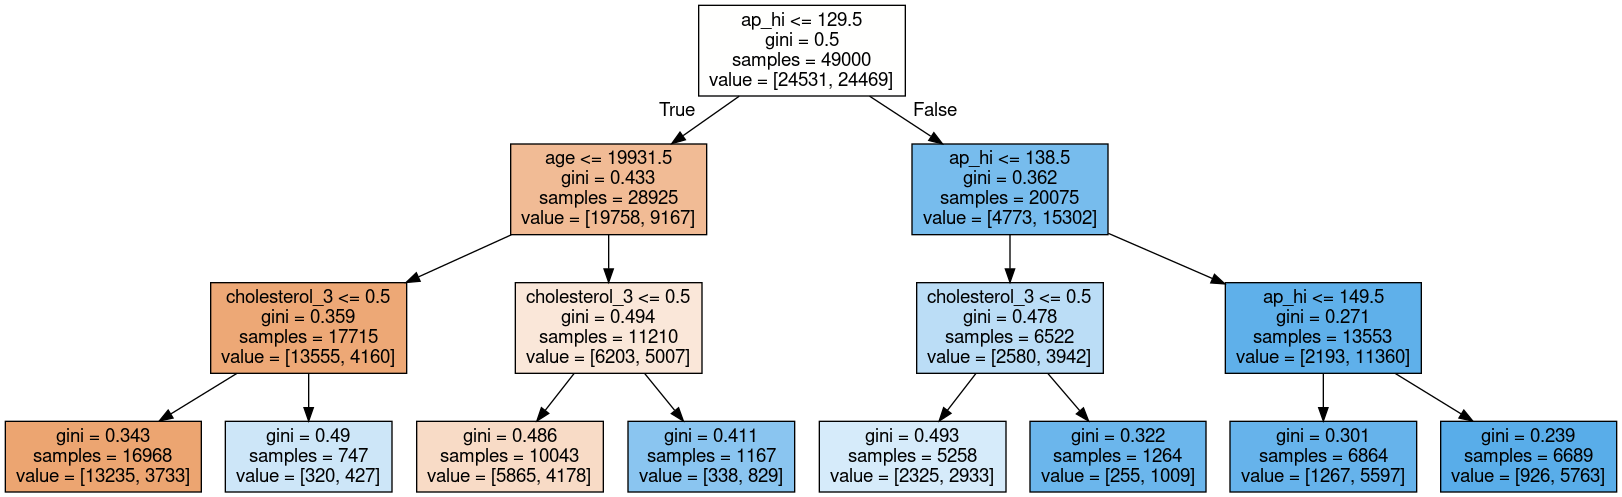

In [14]:
dot_data = StringIO()
export_graphviz(tree, feature_names=train_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**3. Какие 3 признака используются для прогнозирования в созданном дереве решений?**
- age, ap_lo, chol=1
- age, ap_hi, chol=3
- smoke, age, gender
- alco, weight, gluc=3

Ответ: age, ap_hi, chol=3

Сделаем прогнозы для данных удержания `(X_valid, y_valid)` с помощью обученного дерева решений. Рассчитаем accuracy.

In [15]:
pred_valid = tree.predict(X_valid)

In [16]:
tree_acc_valid = accuracy_score(y_valid, pred_valid)
tree_acc_valid

0.7212857142857143

Настроим глубину дерева с помощью кросс-валидации на наборе данных `(X_train, y_train)` для повышения качества модели. Используем `GridSearchCV` с 5 перекрестными проверками. Установим `random_state=17` и будем изменять `max_depth` с 2 на 10.

In [17]:
%%time

tree_params = {
    "max_depth": list(range(2, 11))
}

tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=17),
    param_grid=tree_params,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

tree_grid.fit(X_train, y_train)

CPU times: user 173 ms, sys: 116 ms, total: 288 ms
Wall time: 1.32 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

Построим график изменения средней accuracy в зависимости от значения `max_depth` при кросс-валидации.

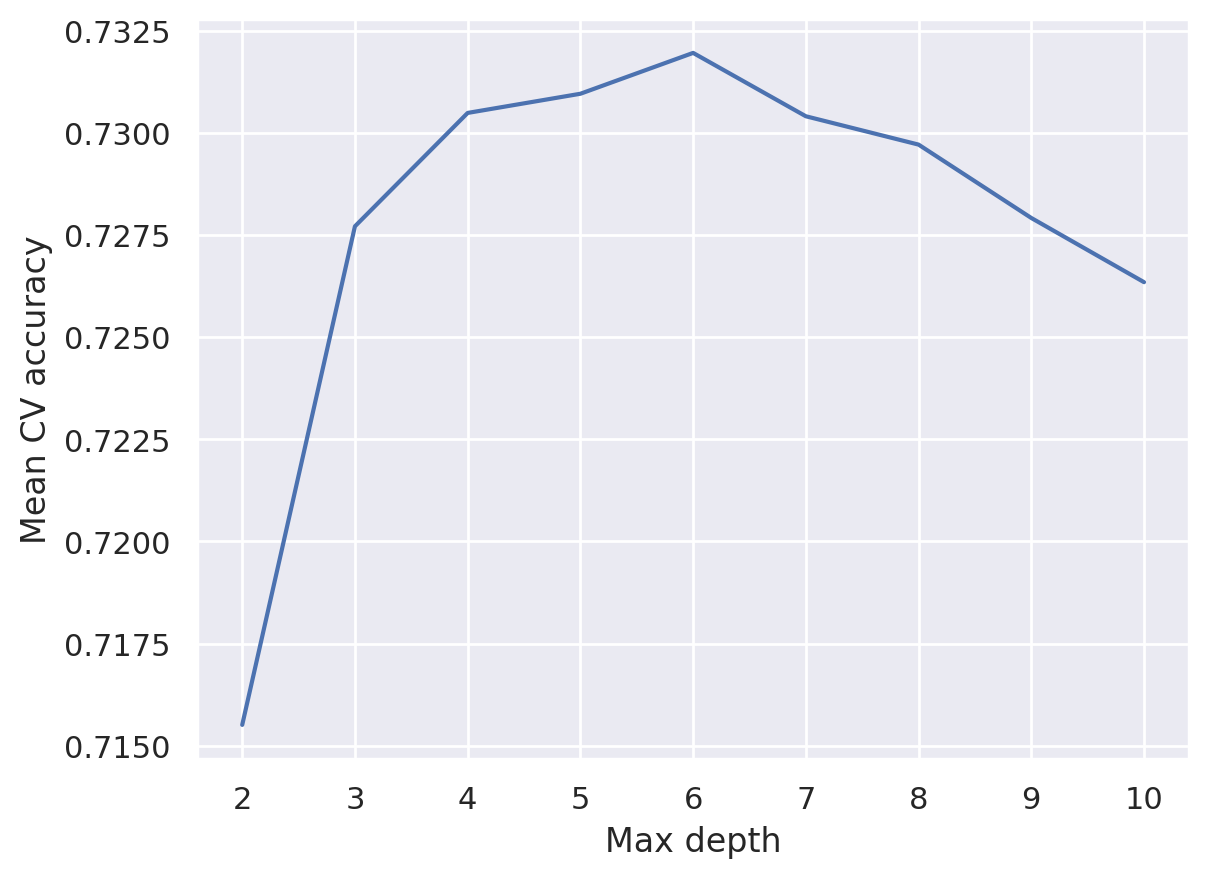

In [18]:
plt.plot(tree_params["max_depth"], tree_grid.cv_results_["mean_test_score"])
plt.xlabel("Max depth")
plt.ylabel("Mean CV accuracy");

Выведем наилучшее значение `max_depth`, при котором среднее значение метрики качества кросс-валидации достигает максимума. Также вычислим точность на удержанных данных. Это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [19]:
print(f"Best params: {tree_grid.best_params_}")
print(f"Best cross validaton score: {tree_grid.best_score_}")

Best params: {'max_depth': 6}
Best cross validaton score: 0.7319591836734693


In [20]:
tuned_tree_acc_valid = accuracy_score(y_valid, tree_grid.predict(X_valid))
tuned_tree_acc_valid

0.7258095238095238

Вычислить эффект от `GridSearchCV`: проверить выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 - точности на holdout-данных до и после настройки max_depth с помощью GridSearchCV соответственно.

In [21]:
(tuned_tree_acc_valid - tree_acc_valid) / tree_acc_valid * 100

0.6271869016967002

**4. Выберите все правильные утверждения:**
- Существует локальный максимум точности на построенной кривой валидации;
- `GridSearchCV` увеличил точность удержания на **более** чем 1%;
- Локальный максимум точности на построенной валидационной кривой **не существует**;
- `GridSearchCV` увеличил точность удержания на **менее** чем на 1%.

Ответы: 1, 4

На сайте Европейского общества кардиологов приведена шкала [SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645). Она используется для расчета риска смерти от сердечно-сосудистых заболеваний в ближайшие 10 лет. Вот она:
<img src='../img/SCORE2007-eng.png' width=70%>

Создадим новые признаки в соответствии с этим рисунком:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 признака);
- систолическое артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака).

Если значения возраста или артериального давления не попадают ни в один из интервалов, то все бинарные признаки будут равны нулю.

Добавим признак ``smoke``.

Построить признаки ``cholesterol`` и ``gender``. Преобразуем признак ``cholesterol`` в 3 бинарных признака в соответствии с его тремя уникальными значениями ( ``cholesterol``=1, ``cholesterol``=2 и ``cholesterol``=3). Преобразуем ``gender`` из 1 и 2 в 0 и 1. Лучше переименовать его в ``male`` (0 - женщина, 1 - мужчина). Обычно это делается с помощью ``sklearn.preprocessing.LabelEncoder``, но в данном случае, когда имеется только 2 уникальных значения, это не обязательно.

Наконец, по этим 12 бинарным признакам строится дерево решений (без учета всех исходных признаков, которые были у нас до этой части работы с признаками).

Создайте дерево решений с ограничением `max_depth=3` и обучите его на всех обучающих данных. Используйте класс `DecisionTreeClassifier` с фиксированным `random_state=17`, а все остальные аргументы (кроме `max_depth` и `random_state`) оставьте со значениями по умолчанию.

In [22]:
sub_df = pd.DataFrame(df.smoke.copy())
sub_df["male"] = df.gender - 1

sub_df["age_40_50"] = ((df.age_years >= 40) & (df.age_years < 50)).astype("int")
sub_df["age_50_55"] = ((df.age_years >= 50) & (df.age_years < 55)).astype("int")
sub_df["age_55_60"] = ((df.age_years >= 55) & (df.age_years < 60)).astype("int")
sub_df["age_60_65"] = ((df.age_years >= 60) & (df.age_years < 65)).astype("int")

sub_df["ap_hi_120_140"] = ((df.ap_hi >= 120) & (df.ap_hi < 140)).astype("int")
sub_df["ap_hi_140_160"] = ((df.ap_hi >= 140) & (df.ap_hi < 160)).astype("int")
sub_df["ap_hi_160_180"] = ((df.ap_hi >= 160) & (df.ap_hi < 180)).astype("int")

sub_df["chol=1"] = (df.cholesterol == 1).astype("int")
sub_df["chol=2"] = (df.cholesterol == 2).astype("int")
sub_df["chol=3"] = (df.cholesterol == 3).astype("int")

In [23]:
sub_df.head()

,smoke,male,age_40_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0


In [24]:
clf = DecisionTreeClassifier(max_depth=3, random_state=17).fit(sub_df, target)

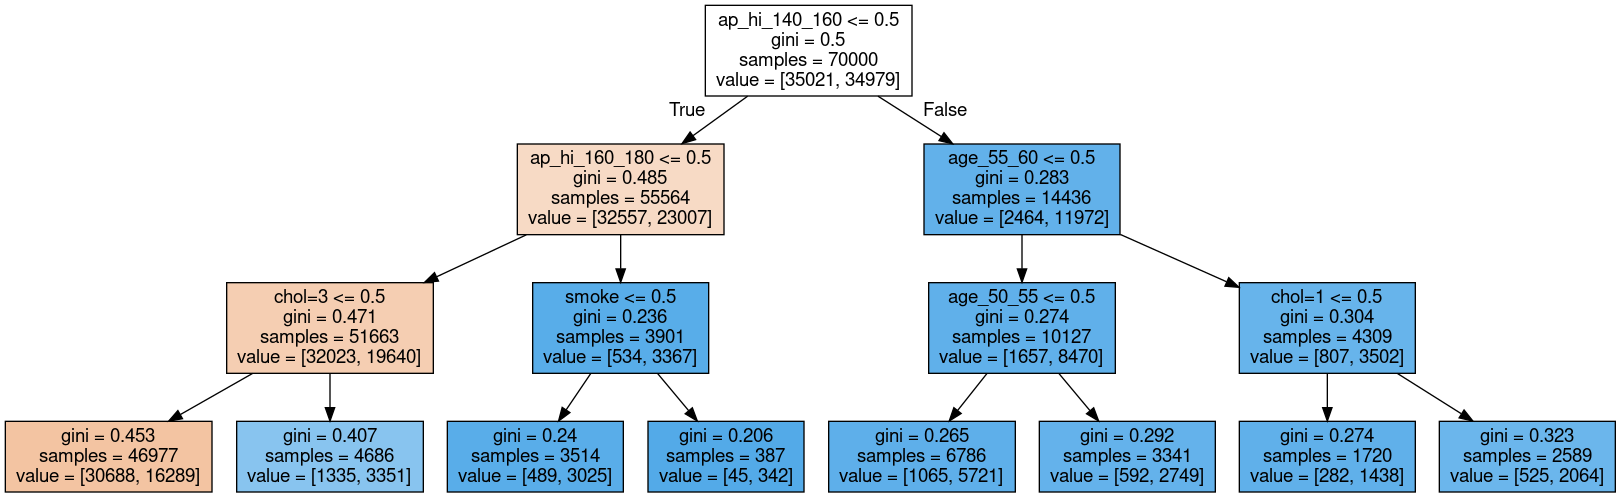

In [25]:
dot_data = StringIO()
export_graphviz(clf, feature_names=sub_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**5. Какой из бинарных признаков является наиболее важным для выявления сердечно-сосудистых заболеваний (т.е. помещается в корень дерева)?**
- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3
- Systolic blood pressure from 140 to 160 (mmHg)
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

Ответ: 3. Systolic blood pressure from 140 to 160 (mmHg)